# Lentes Gravitacionales
---
- **Máster de Física Avanzada de la Universidad de Valencia**
- **Cosmología**

## 0. Librerías y Configuración del Sistema

### 0.1. Librerías
---
**healpy**


In [1]:
!pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 27.7 MB/s eta 0:00:00


In [2]:
try:
    from google.colab import drive
    COLAB = True
    print("Entorno detectado: Google Colab")
    drive.mount('/content/drive')

    PATH = '/content/drive/MyDrive'
    print(f"Drive montado en: {PATH}")

except ImportError:
    COLAB = False
    PATH = os.getcwd()  # ruta local actual
    print(" Entorno local detectado (no Colab).")
    print(f"Directorio de trabajo: {PATH}")


Entorno detectado: Google Colab
Mounted at /content/drive
Drive montado en: /content/drive/MyDrive


In [3]:
####################################

import os
import time
from datetime import datetime
import requests
from PIL import Image
import io

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

from IPython.display import HTML
from IPython.display import Image

import numpy as np
from math import pi

import astropy.units as u
from astropy.io import fits
from scipy.signal import find_peaks

try:
    import torch
    import torch.fft as fft
    import torch.nn.functional as F
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False

try:
    import healpy as hp
    _HAS_HEALPY = True
except:
    from joblib import Parallel, delayed
    from scipy.special import sph_harm
 #   from astropy_healpix import HEALPix
    _HAS_HEALPY = False


### 0.2 Chequeo del Sistema
---


In [4]:
print('\nTorch/CUDA Info:\n-----------------------')
if _HAS_TORCH:
    cuda = torch.cuda.is_available()
    print('Torch Version:', torch.__version__)
    print('Torch CUDA available:', cuda)
    if cuda:
        print("torch_cuda_version:",torch.version.cuda)
        ngpu = torch.cuda.device_count()
        for i in range(ngpu):
            print("Index:", i,"| Name:", torch.cuda.get_device_name(i),
                "| Capability:", "".join(str(x) for x in torch.cuda.get_device_capability(i)),
                "| Total Memory (GB):", "{:.2f}".format(torch.cuda.get_device_properties(i).total_memory/1024**3))
print('\nModule Version:\n-----------------------')
if _HAS_HEALPY:
    for module, name in zip([hp, np],["healpy","numpy"]):
        print(name,'version:', module.__version__)
else:
    for module, name in zip([np],["healpy","numpy"]):
        print(name,'version:', module.__version__)


Torch/CUDA Info:
-----------------------
Torch Version: 2.8.0+cu126
Torch CUDA available: False

Module Version:
-----------------------
healpy version: 1.18.1
numpy version: 2.0.2


## 1. Descarga de Imágenes Astrónomicas
---
Varias Opciones de Descarga en Repositorios públicos:

**1. Servicio HiPS2FITS**

- Recorte de imágenes de mapas astronómicos
- Catálogos HiPS (DSS, SDSS, PanSTARRS, etc)
- Permite generar recortes FITS de tamaño arbítrario desde
- https://alasky.cds.unistra.fr/hips-image-services/hips2fits
  
**2. Servicio SDSS:**
- Recortes JPEG vía API de SDSS SkyServer
- Imágenes en Color.
- Solo Cubre una franja en el hemisferio Norte:
$$7^h<RA<17^h \quad(105^\circ<RA<255^\circ),\quad\qquad -10^\circ<Dec<+70^\circ$$
- https://skyserver.sdss.org/dr16/en/tools/getimg/getimghome.aspx

### 1.1. Parámetros - Descarga de los Mapas del CMB

In [5]:
DOWNLOAD_SERVICE = 'HIPS'
CATALOGO         = 'DSS2'

RA, DEC          = 168.6958, 55.0189 # Grados
FOV              = 0.05               # Grados
PIX_X, PIX_Y     = 1024, 1024         # Resolución en Pixeles de la imagen
PROYECCION       = 'TAN'

# Diccionario con estrellas brillantes y sus coordenadas (J2000) en grados
# RA expresada en grados (0 a 360), Dec en grados (-90 a +90)

estrellas = {
    "Sirius":       {"RA": 101.2870833, "Dec": -16.7161111},  # α CMa
    "Canopus":      {"RA": 95.9879167,  "Dec": -52.6955556},  # α Car
    "Arcturus":     {"RA": 213.9154167, "Dec": +19.1825},     # α Boo
    "Alpha Centauri": {"RA": 219.9020833, "Dec": -60.8338889},# α Cen
    "Vega":         {"RA": 279.2345833, "Dec": +38.7836111},  # α Lyr
    "Capella":      {"RA": 79.1725,     "Dec": +45.9977778},  # α Aur
    "Rigel":        {"RA": 78.63375,    "Dec": -8.2016667},   # β Ori
    "Procyon":      {"RA": 114.8254167, "Dec": +5.225},       # α CMi
    "Achernar":     {"RA": 24.4283333,  "Dec": -57.2366667},  # α Eri
    "Betelgeuse":   {"RA": 88.7929167,  "Dec": +7.4069444},   # α Ori
    "Altair":       {"RA": 297.6958333, "Dec": +8.8666667},   # α Aql
    "Aldebaran":    {"RA": 68.9804167,  "Dec": +16.5088889},  # α Tau
    "Antares":      {"RA": 247.351875,  "Dec": -26.4327778},  # α Sco
    "Spica":        {"RA": 201.2983333, "Dec": -11.1613889},  # α Vir
    "Pollux":       {"RA": 116.3289167, "Dec": +28.0261111},  # β Gem
    "Deneb":        {"RA": 310.3579167, "Dec": +45.2802778},  # α Cyg
    "Polaris":      {"RA": 37.9545417, "Dec": +89.2641111}
}

# Diccionario con galaxias brillantes y conocidas, coordenadas J2000 en grados

galaxias = {
    "Andromeda (M31)":    {"RA": 10.6847083,  "Dec": +41.26875,   "z": -0.001},   # movimiento local hacia nosotros
    "Triangulum (M33)":   {"RA": 23.4620833,  "Dec": +30.6597222, "z": 0.0006},
    "Sombrero (M104)":    {"RA": 189.9970833, "Dec": -11.6230556, "z": 0.0034},
    "Whirlpool (M51)":    {"RA": 202.4695833, "Dec": +47.1952778, "z": 0.0015},
    "Pinwheel (M101)":    {"RA": 210.8020833, "Dec": +54.3488889, "z": 0.0008},
    "Messier 87 (M87)":   {"RA": 187.7059167, "Dec": +12.3911111, "z": 0.0043},
    "Messier 81 (M81)":   {"RA": 148.8882083, "Dec": +69.0652778, "z": -0.0001},  # muy local
    "Messier 82 (M82)":   {"RA": 148.9684583, "Dec": +69.6797222, "z": 0.0007},
    "Centaurus A (NGC 5128)": {"RA": 201.3650625, "Dec": -43.019112, "z": 0.0018},
    "Large Magellanic Cloud (LMC)": {"RA": 80.8941667, "Dec": -69.7561111, "z": 0.00093},
    "Small Magellanic Cloud (SMC)": {"RA": 13.1583333, "Dec": -72.800278, "z": 0.00053},
    "NGC 4889 (Coma Cluster)": {"RA": 195.0333, "Dec": +27.9775, "z": 0.021},
    "NGC 4874 (Coma Cluster)": {"RA": 194.8988, "Dec": +27.9594, "z": 0.022},
    "3C 273 (Quásar)":         {"RA": 187.2779, "Dec": +2.0524,  "z": 0.158},
    "NGC 1275 (Perseus A)":    {"RA": 49.9507,  "Dec": +41.5117, "z": 0.0176},
    "MACS J1149.5+2223":       {"RA": 177.3988, "Dec": +22.3980, "z": 0.544},
    "Abell 1689":              {"RA": 197.8733, "Dec": -1.3400,  "z": 0.183},
    "El Gordo (ACT-CL J0102-4915)": {"RA": 15.7270, "Dec": -49.2478, "z": 0.87},
    "GN-z11 (galaxia más lejana conocida ~2023)": {"RA": 189.2292, "Dec": +62.2700, "z": 11.09}
}

OBJETO = 'NGC 4889 (Coma Cluster)'
CATEGORIA = galaxias
COORD = CATEGORIA[OBJETO]


### 1.2. Servicio HiPS2FITS (https://irsa.ipac.caltech.edu/)

In [6]:
def fetch_hips2fits_cutout(catalogo: str,
                          coord,
                          fov: float,
                          width: int, height: int,
                          projection: str = "TAN",
                          debug = True):
    """
    Solicita un recorte FITS desde el servicio hips2fits del CDS / Alasky.
    Retorna un objeto astropy.io.fits.HDUList si tiene éxito.
    """
    base_url = "http://alasky.cds.unistra.fr/hips-image-services/hips2fits"
    # parámetros
    params = {
        "hips": catalogo,
        "ra": coord['RA'],
        "dec": coord['Dec'],
        "fov": fov,
        "width": width,
        "height": height,
        "projection": projection
    }

    # solicitar
    resp = requests.get(base_url, params=params)
    resp.raise_for_status()
    # el contenido debe ser un FITS
    from io import BytesIO
    hdul = fits.open(BytesIO(resp.content))
    if debug:
        print(hdul.info())
    data = None
    for hdu in hdul:
        if hdu.data is not None:
            data = hdu.data
            break
    data = np.ascontiguousarray(data.astype(np.float32))
    return data



### 1.3. Servicio SDSS (http://skyserver.sdss.org/)

In [7]:
def fetch_sdss_cutout(coord,
                      fov: float,
                      width: int, height: int,
                      opt: str = ""):
    """
    Solicita un recorte JPEG del SDSS.
    Retorna un objeto PIL Image.
    """
    base = "http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg"
    scale = (FOV*3600)/width
    params = {
        "ra": coord['RA'],
        "dec": coord['Dec'],
        "scale": scale,  # arcsec/pixel
        "width": width,
        "height": height,
        "opt": opt
    }
    resp = requests.get(base, params=params)
    resp.raise_for_status()
    image = Image.open(io.BytesIO(resp.content))
    return np.array(image)

### 1.4. Descarga de la Imagen Astrónomica

In [8]:
def get_Image_Astro(coord, fov = FOV, width = PIX_X, height = PIX_Y, debug=False):
    if DOWNLOAD_SERVICE == 'HIPS':
        image = fetch_hips2fits_cutout(catalogo = CATALOGO,
                               coord = coord, fov = fov,
                               width = width, height = height,
                               projection = PROYECCION,
                               debug=False)

    elif DOWNLOAD_SERVICE == 'SDSS':
        image = fetch_sdss_cutout(coord = coord, fov = fov,
                                  width = width, height = height,
                                  )
    else:
        image = None
    return image

image_astro = get_Image_Astro(coord=COORD)
if image_astro is not None:
    print(f'Imagen descargada correctamente de {DOWNLOAD_SERVICE} --> COORD = {COORD}')#['RA']:.2f}, DEC = {COORD['DEC']:.2f},  fov={FOV:.2f}°')
    print(f'Tamaño de la imagen: {image_astro.shape}')

Imagen descargada correctamente de HIPS --> COORD = {'RA': 195.0333, 'Dec': 27.9775, 'z': 0.021}
Tamaño de la imagen: (1024, 1024)


### 1.5. Análisis y Visualización de la Imagen

Dimensiones de la imagen: (1024, 1024)
Nivel medio del fondo: 5884.79 ADU
Mediana del fondo: 5362.00 ADU
Ruido (desviación estándar): 1954.55 ADU
Campo de Visión (FOV): 0.05 grados = 180.00 arcoseg
Objeto más brillante en píxel: (np.int64(493), np.int64(494)), valor=24144.0


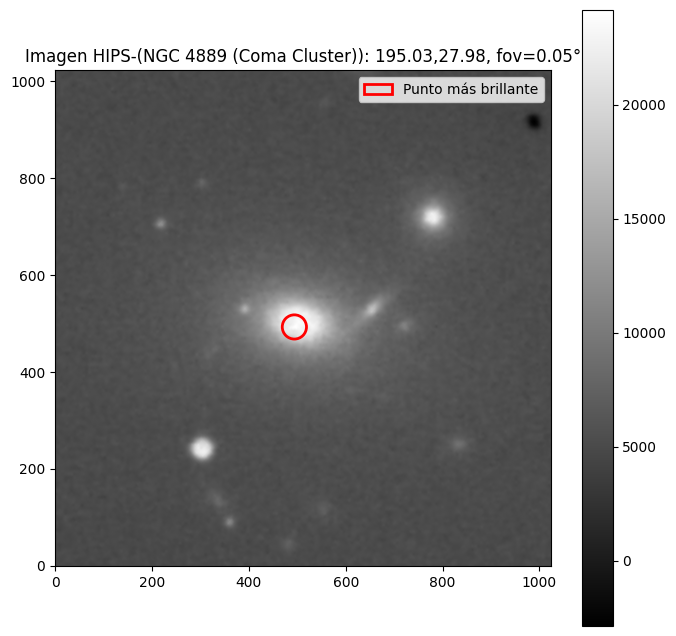

In [9]:
# Estadísticas básicas
mean_val = np.mean(image_astro)
median_val = np.median(image_astro)
std_val = np.std(image_astro)
print(f"Dimensiones de la imagen: {image_astro.shape}")
print(f"Nivel medio del fondo: {mean_val:.2f} ADU")
print(f"Mediana del fondo: {median_val:.2f} ADU")
print(f"Ruido (desviación estándar): {std_val:.2f} ADU")
print(f"Campo de Visión (FOV): {FOV} grados = {FOV*3600:.2f} arcoseg")
# Localizar píxel más brillante (posible estrella/galaxia brillante)
brightest = np.unravel_index(np.argmax(image_astro), image_astro.shape)
print(f"Objeto más brillante en píxel: {brightest}, valor={image_astro[brightest]:.1f}")

# Visualización de la Imagen
if image_astro is not None:
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(image_astro, origin='lower', cmap='gray')
    plt.colorbar(im, ax=ax)
    ax.set_title(f"Imagen {DOWNLOAD_SERVICE}-({OBJETO}): {COORD['RA']:.2f},{COORD['Dec']:.2f}, fov={FOV:.2f}°")

    # Localizar píxel más brillante
    brightest = np.unravel_index(np.argmax(image_astro), image_astro.shape)

    # Dibujar círculo en el píxel más brillante
    circ = plt.Circle((brightest[1], brightest[0]), radius=25,
                      edgecolor='red', facecolor='none', lw=2, label="Punto más brillante")
    ax.add_patch(circ)

    # Opcional: añadir texto con coordenadas del píxel
    #ax.text(brightest[1]+12, brightest[0], "Más brillante", color="red", fontsize=10)

    plt.legend(loc="upper right")
    plt.show()
else:
    print("La Imagen no se ha podido descargar del servicio:", DOWNLOAD_SERVICE)



## 2. Preparación para la Simulación

### 2.1. Funciones Cosmológicas

In [10]:
# -------------------------
# Funciones cosmológicas simples (aprox. plano FRW)
# -------------------------
from scipy.integrate import quad

def E_inv(z):
    """1/E(z) para integral comóvil"""
    return 1.0/np.sqrt(Omega_m*(1+z)**3 + Omega_L)

def comoving_distance(z):
    """Distancia comóvil en Mpc"""
    integral, _ = quad(E_inv, 0, z)
    return (c/H0) * integral  # Mpc

def angular_diameter_distance(z1, z2=None):
    """
    Distancia angular [Mpc].
    Si solo z1: desde 0 hasta z1.
    Si z1<z2: entre z1 y z2.
    """
    if z2 is None:
        Dc = comoving_distance(z1)
        return Dc/(1+z1)
    else:
        Dc1 = comoving_distance(z1)
        Dc2 = comoving_distance(z2)
        return (Dc2 - Dc1)/(1+z2)

# -------------------------
# Radio de Einstein (masa puntual)
# -------------------------
def theta_E_point_mass(M_Msun, Dd, Ds, Dds):
    """Radio de Einstein [radianes] para lente puntual"""
    M = M_Msun * M_sun
    numerator = 4*G_SI*M/(c*1000)**2 * (Dds* Mpc)
    denominator = (Dd* Mpc) * (Ds* Mpc)
    return np.sqrt(numerator/denominator)

# -------------------------
# Radio de Einstein (SIS)
# -------------------------
def theta_E_SIS(sigma_v, Ds, Dds):
    """Radio de Einstein [radianes] para SIS"""
    return 4*np.pi*(sigma_v/c)**2 * (Dds/Ds)


### 2.2. Parámetros de La Simulación
---
**Parámetros Cosmológicos:**

- Constante de Hubble $ H_0 $ (e.g., 67 km/s/Mpc): Afecta distancias $ D $.
- Densidades $ \Omega_m, \Omega_\Lambda, \Omega_k $: Determinan la geometría (plana si $ \Omega_k = 0 $) y expansión $ H(z) $.
- Redshifts $ z_L $ (lente) y $ z_S $ (fuente): Para calcular distancias angulares $ D_L, D_S, D_{LS} $.

**Parámetros de la Lente:**

- Masa total, M
- Perfil de densidad, $\rho$. Utilizado en el caso de masa distribuida SIS. El ejemplo típico suele ser una esfera isotérmica singular, $ \rho \propto r^{-2} $.

**Parámetros de la Fuente:**

- Posición angular $ \vec{\beta} $, brillo intrínseco y morfología (e.g., disco, punto para quásar).
- Espectro de emisión (para lentes cromáticas, si se simula dispersión).

**Parámetros Numéricos de Simulación:**

- Resolución espacial (e.g., grid size para ray-tracing, 1024x1024 píxeles).
- Número de rayos o iteraciones (para convergencia en solvers no lineales).
- Ruido instrumental y resolución angular (e.g., beam de telescopio como HST o JWST).

In [11]:
#-------------------------
# Parámetros cosmológicos
# -------------------------
H0 = 70.0  # Constante de Hubble [km/s/Mpc]
c_km = 3.0e5  # velocidad de la luz [km/s]
c = 2.99792458e5  # km/s (más preciso)

Omega_m = 0.5
Omega_L = 1.0

# -------------------------
# Redshifts
# -------------------------
z_d = 0.01   # redshift de la lente
z_s = 1.5   # redshift de la fuente

# -------------------------
# Distancias angulares
# -------------------------
Dd = angular_diameter_distance(z_d)      # observador-lente
Ds = angular_diameter_distance(z_s)      # observador-fuente
Dds = angular_diameter_distance(z_d, z_s)  # lente-fuente

# -------------------------
# Parámetros de la lente (ejemplo masa puntual o SIS)
# -------------------------
M_lens = 1.0e12  # masa de la lente [M_sun]
sigma_v = 220.0  # dispersión de velocidad [km/s] (para SIS)

# -------------------------
# Conversiones de unidades
# -------------------------
M_sun = 1.98847e30  # kg
G_SI = 6.67430e-11  # m^3/kg/s^2

pc = 3.0856775814913673e16  # m
Mpc = 1.0e6 * pc            # m
rad2arcsec = 206265.0       # 1 rad = 206265 arcsec =(180/PI) * 3600

theta_E_rad = theta_E_point_mass(M_lens, Dd, Ds, Dds)
theta_E_arcsec = theta_E_rad * rad2arcsec
theta_E_sis_rad = theta_E_SIS(sigma_v, Ds, Dds)
theta_E_sis_arcsec = theta_E_sis_rad * rad2arcsec

print(">> Cosmología\n",'*'*30)
print(f"H0       = {H0:.1f} km/s/Mpc")
print(f"c        = {c:.3e} km/s")
print(f"Ω_m      = {Omega_m}")
print(f"Ω_Λ      = {Omega_L}\n")

print(">> Redshifts\n",'*'*30)
print(f"z_d (lente)   = {z_d}")
print(f"z_s (fuente)  = {z_s}\n")

print(">> Lente gravitacional\n",'*'*30)
print(f"M_lens  = {M_lens:.2e} M_sun")
print(f"sigma_v = {sigma_v:.1f} km/s\n")

print(">> Distancias angulares\n",'*'*30)
print(f"Dd  = {Dd:.2f} Mpc")
print(f"Ds  = {Ds:.2f} Mpc")
print(f"Dds = {Dds:.2f} Mpc")
print("\n>> Radio de Einstein\n",'*'*30)
print(f"Radio de Einstein (masa puntual): {theta_E_arcsec:.3f} arcsec ({theta_E_rad:.6f} radianes)")
print(f"Radio de Einstein (SIS): {theta_E_sis_arcsec:.3f} arcsec")
print(f'FOV: {FOV}ª = {FOV*3600} arcsec = {FOV*np.pi/180.0} radianes')


>> Cosmología
 ******************************
H0       = 70.0 km/s/Mpc
c        = 2.998e+05 km/s
Ω_m      = 0.5
Ω_Λ      = 1.0

>> Redshifts
 ******************************
z_d (lente)   = 0.01
z_s (fuente)  = 1.5

>> Lente gravitacional
 ******************************
M_lens  = 1.00e+12 M_sun
sigma_v = 220.0 km/s

>> Distancias angulares
 ******************************
Dd  = 34.54 Mpc
Ds  = 1391.10 Mpc
Dds = 1377.15 Mpc

>> Radio de Einstein
 ******************************
Radio de Einstein (masa puntual): 15.279 arcsec (0.000074 radianes)
Radio de Einstein (SIS): 1.382 arcsec
FOV: 0.05ª = 180.0 arcsec = 0.0008726646259971648 radianes


## 3. Lentes Gravitacionales Puntuales
---
- **Ángulo de Desviación** $ \vec{\alpha} $: Para una lente puntual (masa M), el ángulo de desviación es:
$$\hat{\alpha} = \frac{4GM}{c^2 b}$$
donde $ G $ es la constante gravitacional, $ c $ la velocidad de la luz, y $ b $ el parámetro de impacto (distancia mínima entre la trayectoria de la luz y la lente).
- **Ecuación de Lente**: Relaciona la posición verdadera de la fuente $ \vec{\beta} $ con la posición observada de la imagen $ \vec{\theta} $:
$$\vec{\beta} = \vec{\theta} - \vec{\alpha}(\vec{\theta})$$
Esta es una ecuación no lineal que se resuelve numéricamente en simulaciones para encontrar imágenes múltiples. En términos adimensionales, se usa el potencial de lente $ \psi(\vec{\theta}) $:
$$\psi(\vec{\theta}) = \frac{1}{\pi} \int \kappa(\vec{\theta}') \ln|\vec{\theta} - \vec{\theta}'| d^2\theta'$$
donde $ \kappa = \Sigma / \Sigma_{cr} $ es la convergencia, y $ \Sigma_{cr} = \frac{c^2}{4\pi G} \frac{D_S}{D_L D_{LS}} $ la densidad crítica, con $ D_L, D_S, D_{LS} $ distancias angulares a la lente, fuente y entre ellas.
- **Magnificación y Distorsión**: La matriz jacobiana del mapeo de lente da la magnificación $ \mu = 1 / \det(A) $, donde $ A = \frac{\partial \vec{\beta}}{\partial \vec{\theta}} = I - \frac{\partial \vec{\alpha}}{\partial \vec{\theta}} $. Para lentes débiles, se descompone en convergencia $ \kappa $ y cizalla $ \gamma $:
$$A = \begin{pmatrix} 1 - \kappa - \gamma_1 & -\gamma_2 \\ -\gamma_2 & 1 - \kappa + \gamma_1 \end{pmatrix}$$

- **Radio de Einstein** $ \theta_E $: Escala angular característica para lentes fuertes:
$$\theta_E = \sqrt{\frac{4GM}{c^2} \frac{D_{LS}}{D_L D_S}}$$
Para M ≈ 10^{12} M_⊙ (galaxia típica), $ \theta_E $ ≈ 1-10 arcosegundos.

En simulaciones, se resuelve numéricamente el trazado de rayos a través de un potencial 3D (e.g., usando N-body para halos de DM) o 2D proyectado, incorporando efectos cosmológicos como redshift y curvatura.

### 3.1. Malla Angular del Plano de la Lente
---
**Geometría de la lente**

- **Plano imagen o Plano Observado** (plano de la lente, coordenadas $\theta$). Es el plano angular en el que el observador mide la posición aparente de los rayos de luz desviados. Aquí definimos la malla
  $$(x,y) \equiv (\theta_x, \theta_y)$$
que son ángulos (aparentes) en el cielo.

**Código**
- El campo de visión, FOV (Field of Vision), correspondiente a la malla teniendo en cuenta la resolución de la imagen
- Definición de la malla angular en el plano de la Lente (Coordenadas $\theta$).


In [12]:
# -----------------------------
# Resolución y FOV equivalente de la simulación
# -----------------------------
N = PIX_X  # resolución de la simulación
fov_rad = FOV * np.pi /180.0      # en radianes
dx = fov_rad / N                  # tamaño angular por píxel [rad]
fov_arcsec = FOV * 3600

# -----------------------------
# Definición campo de visión y malla angular (cmapo de la lente)
# -----------------------------
# malla angular centrada
x = (torch.arange(N) - (N-1)/2.0) * dx
y = (torch.arange(N) - (N-1)/2.0) * dx
yy, xx = torch.meshgrid(y, x, indexing='ij')

print(f'Resolución de la imagen:    {PIX_X} Pixeles')
print(f'Campo de Visión (FOV):      {fov_arcsec} arcsec. = {fov_rad:.5f} radianes')
print(f"Radio de Einstein:          {theta_E_arcsec:.2f} arcsec")
print(f'\nTamaño angular por pixel:   {dx:.2e} radianes/pixel')
print(f'Tamaño angular de laMalla:  {list(xx.shape)}')

print(f'\nRango de la malla (Radianes):\n\t\t X = [ {xx.min().item():.5f}, {yy.min().item():.5f}] \n\t\t Y = [{xx.max().item():.5f}, {yy.max().item():.5f}]')


Resolución de la imagen:    1024 Pixeles
Campo de Visión (FOV):      180.0 arcsec. = 0.00087 radianes
Radio de Einstein:          15.28 arcsec

Tamaño angular por pixel:   8.52e-07 radianes/pixel
Tamaño angular de laMalla:  [1024, 1024]

Rango de la malla (Radianes):
		 X = [ -0.00044, -0.00044] 
		 Y = [0.00044, 0.00044]


### 3.2. Deflexión en el Plano de la Lente, $\hat{\alpha}$ y en el Plano de la Imagen $\alpha$
---
**Geometría de la lente**

- **Plano Lente**. La deflexión producida por una masa puntual, calculada directamente de la Relatividad General es:
$$\vec{\hat{\mathbf{\alpha}}} (b) = \frac{4GM}{c^2}\frac{\vec{\mathbf{ b}}}{b}$$
donde $b=D_d|\theta|$ es el parámetro de impacto en coordenadas físicas y $\vec{\mathbf b}$ es el vector unitario en la dirección de $b$.

- **Plano fuente**. Cuando trasladamos esa deflexión al plano de la fuente, aparece un factor geométrico: $$\vec{\mathbf{\alpha}} (\theta)  = \frac{D_{ds}}{D_s}\,\vec{\hat{\mathbf{\alpha}}} (\theta)$$

Si se combina con la definición anterior (sustituyendo $\alpha(\theta)$ y relacionando $b=D_d|\theta|$, se obtiene:
$$\vec{\mathbf{\alpha}} (\theta)  =\theta^2_E\, \frac{\mathbf{\theta}}{|\theta|^2}$$


**Código**
- Se calcula $\alpha$ el efecto de la deflexión debida a la masa puntual en función de la coordenadas $\vec\theta$ del plano de la lente (utilizando el radio de Einstein, $\theta_E$) en cada punto de dichoplano de la lente.
- Se calcula tanto en el plano de la Lente, $\hat{\alpha}$, como en el plano de la fuente, ${\alpha}$

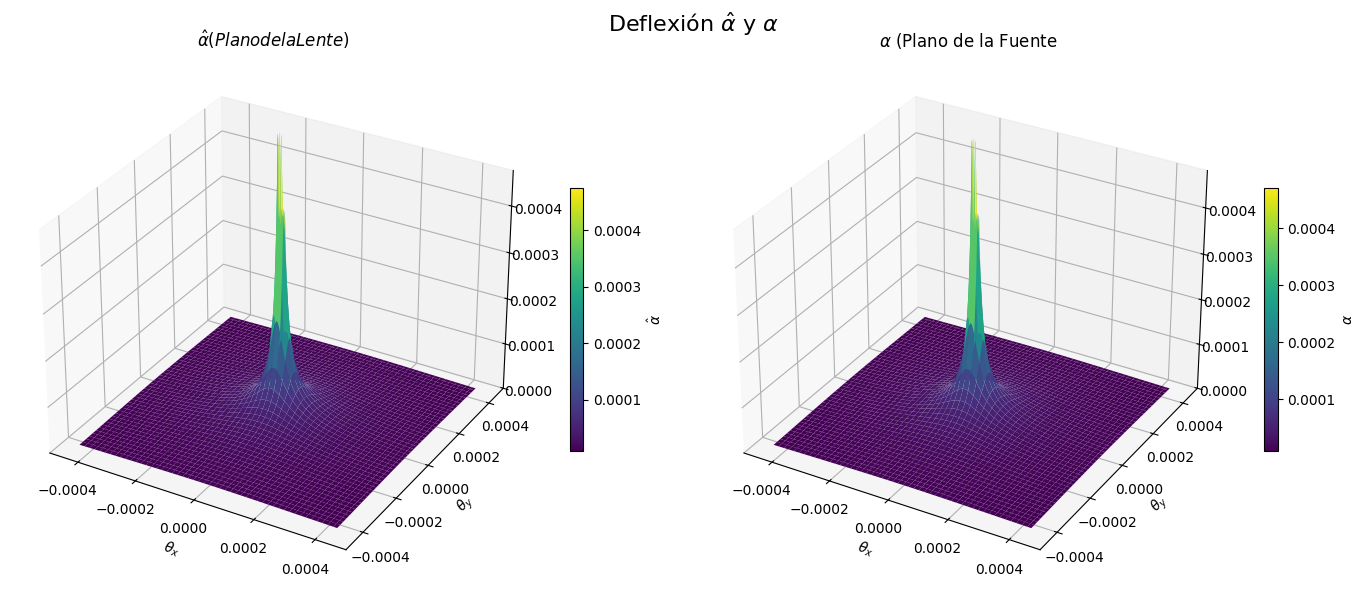

In [13]:

# -----------------------------
# Deflexión (masa puntual)
# -----------------------------
r = torch.sqrt(xx**2 + yy**2) + 1e-12  # Parámetro b para cada pounto de la malla
alpha_x = theta_E_rad**2 * xx / r**2
alpha_y = theta_E_rad**2 * yy / r**2

mask_x = alpha_x > xx.max()
mask_y = alpha_y > yy.max()
alpha_x[mask_x] = xx.max()
alpha_y[mask_y] = yy.max()

mask_x = alpha_x < xx.min()
mask_y = alpha_y < yy.min()
alpha_x[mask_x] = xx.min()
alpha_y[mask_y] = yy.min()

hat_alpha_x = alpha_x * Dds / Ds
hat_alpha_y = alpha_y * Dds / Ds

X = xx.numpy()
Y = yy.numpy()
A = torch.sqrt(alpha_x**2 + alpha_y**2).numpy()  # módulo de alpha
hat_A = torch.sqrt(hat_alpha_x**2 + hat_alpha_y**2).numpy()  # módulo de alpha
# -----------------------------
# Visualización 3D de alpha y alpha^
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

# alpha
surf1 = axes[0].plot_surface(X, Y, A, cmap='viridis', edgecolor='none')
axes[0].set_title(r"$\hat{\alpha} (Plano de la Lente)$")
axes[0].set_xlabel(r"$\theta_x$")
axes[0].set_ylabel(r"$\theta_y$")
#axes[0].set_zlabel(r"$\hat{\alpha}$")
axes[0].set_zlim(0,hat_alpha_x.max()*1.1)
fig.colorbar(surf1, ax=axes[0], shrink=0.5, aspect=20, label=r"$\hat{\alpha}$")

# Sbeta
surf2 = axes[1].plot_surface(X, Y, hat_A, cmap='viridis', edgecolor='none')
axes[1].set_title(r"$\alpha$ (Plano de la Fuente")
axes[1].set_xlabel(r"$\theta_x$")
axes[1].set_ylabel(r"$\theta_y$")
#axes[1].set_zlabel(r"$\alpha$")
axes[1].set_zlim(0,xx.max()*1.1)
fig.colorbar(surf2, ax=axes[1], shrink=0.5, aspect=20, label=r"$\alpha$")

plt.suptitle(r"Deflexión $\hat{\alpha}$ y $\alpha$ ", fontsize=16)
plt.tight_layout()
plt.show()

### 3.3. Malla Angular en el Plano de la Fuente
---
**Geometría de la lente**

-**Plano de la Fuente**. Es el plano angular donde estaría la fuente en ausencia de lente. Las coordenadas, $beta$, describen la posición angular real de la fuente y, por tanto, se obtienen aplicando **la ecuación de la lente**:
$$\vec{\beta}=\vec{\theta}-\vec{\alpha}(\vec\theta)$$
donde $\vec{\alpha}$ es el ángulo de deflexión en el plano de la fuente calculado en el paso anterior

**Código**:
- Se calculan los valors de $\beta$ para cada punto del plano de la Lente. Este valor también corresponde con la posición real en el plano de la fuente.
- Se calcula el valor en Pixeles (teniendo en cuenta la resolución angular, $dx$) y se traslada la malla al centro del plano de la Fuente (en pixeles): $$\mathbf{P} = \frac{\mathbf{\beta}}{dx} - \frac{N-1}{2}$$

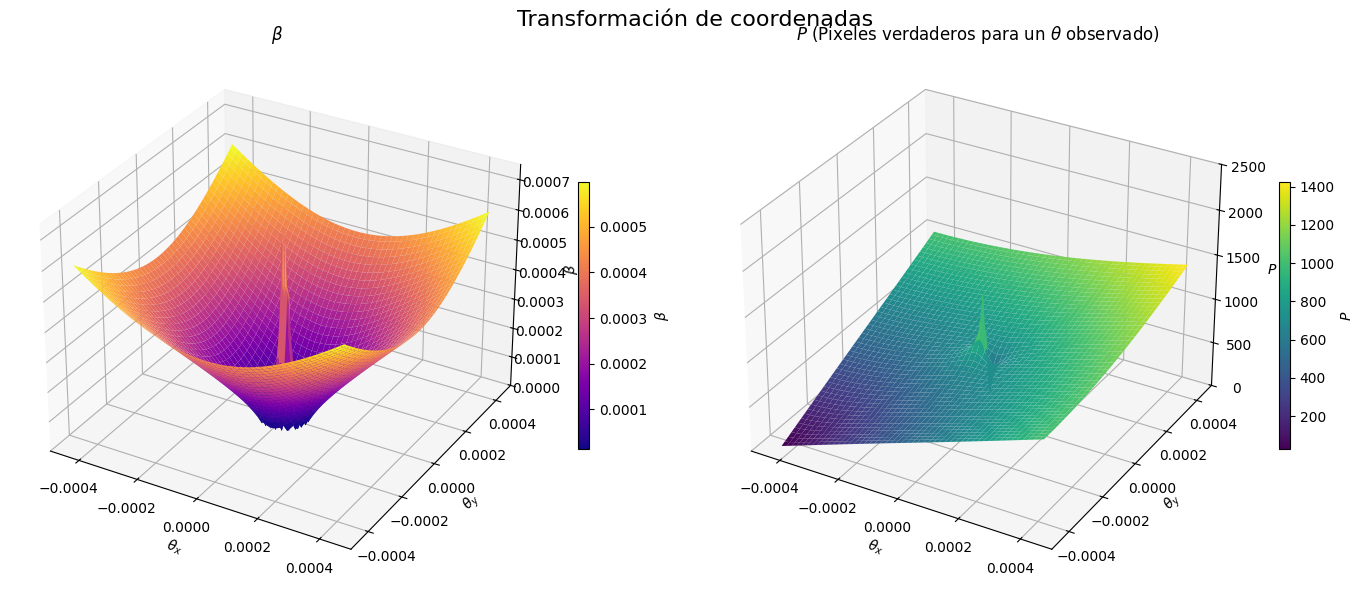

OBSERVACIONES:
 --------------------
 - La masa Puntual está centrada en el origen del plano de la Lente y de la Fuente, $\theta = [0,0]$
 - Al transformar las coordenadas el Pixel [0,0], se corresponde con la esquina inferior izquierda del plano de la fuente
 - La masa puntual (centro del plano) de la Fuente se traslada al pixel $[(N-1)/2, (N-1)/2]$


In [14]:
# ecuación de la lente: beta = theta - alpha
beta_x = xx - alpha_x
beta_y = yy - alpha_y

# convertir beta -> índices de grid_sample en [-1,1]
Px = beta_x / dx +(N-1)/2
Py = beta_y / dx +(N-1)/2

B = torch.sqrt(beta_x**2 + beta_y**2).numpy()  # módulo de beta
P = torch.sqrt(Px**2 + Py**2).numpy()  # módulo de P (distancia en pixeles al centro)

# -----------------------------
# Visualización 3D de P y beta
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})

# beta
surf1 = axes[0].plot_surface(X, Y, B, cmap='plasma', edgecolor='none')
axes[0].set_title(r"$\beta$")
axes[0].set_xlabel(r"$\theta_x$")
axes[0].set_ylabel(r"$\theta_y$")
axes[0].set_zlabel(r"$\beta$")
axes[0].set_zlim(0,0.015*FOV)
fig.colorbar(surf1, ax=axes[0], shrink=0.5, aspect=25, label=r"$\beta$")

# Pixeles
surf2 = axes[1].plot_surface(X, Y, P, cmap='viridis', edgecolor='none')
axes[1].set_title(r"$P$ (Pixeles verdaderos para un $\theta$ observado)")
axes[1].set_xlabel(r"$\theta_x$")
axes[1].set_ylabel(r"$\theta_y$")
axes[1].set_zlabel(r"$P$")
axes[1].set_zlim(0,2500)
fig.colorbar(surf2, ax=axes[1], shrink=0.5, aspect=25, label=r"$P$")

plt.suptitle(r"Transformación de coordenadas", fontsize=16)
plt.tight_layout()
plt.show()
print('OBSERVACIONES:\n','-'*20)
print(r' - La masa Puntual está centrada en el origen del plano de la Lente y de la Fuente, $\theta = [0,0]$')
print(' - Al transformar las coordenadas el Pixel [0,0], se corresponde con la esquina inferior izquierda del plano de la fuente')
print(r' - La masa puntual (centro del plano) de la Fuente se traslada al pixel $[(N-1)/2, (N-1)/2]$')


### 3.4. Ray Shooting de la imagen Fuente
---
Se realiza la transformación **punto a punto** del plano de la fuente utilizando la correspondencia con $\beta$

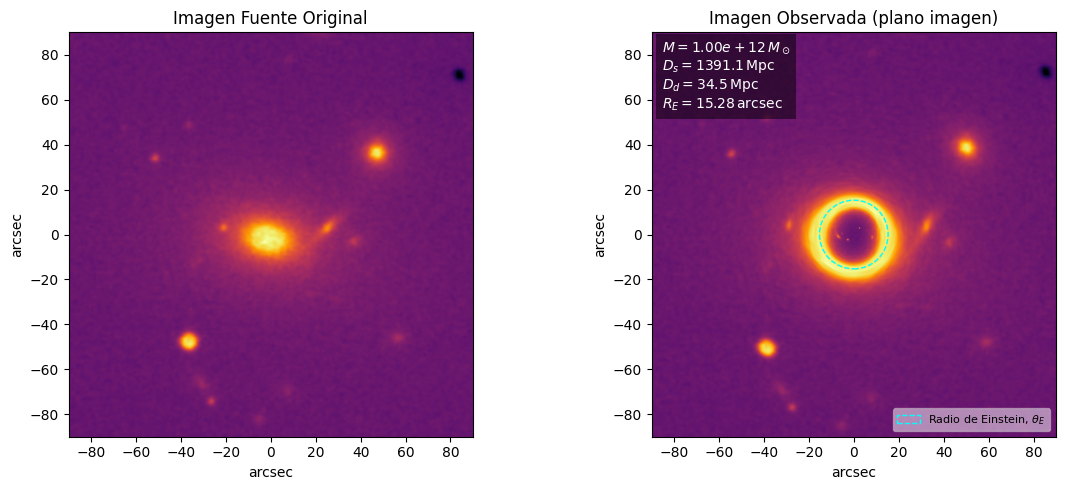

In [15]:
# -----------------------------
# Imagen fuente
# -----------------------------
src = torch.zeros((1, N, N))
if len(image_astro.shape)==3:
    src[0] = torch.from_numpy(image_astro[:,:,0])
else:
    src[0] = torch.from_numpy(image_astro)

# Disco Gaussiano Brillante como fuente
#r_src = torch.sqrt((xx)**2 + (yy)**2)
#src[0] = torch.exp(-(r_src/(20.3*theta_E_rad))**2)  # gauss centrada

# -----------------------------
# Ray-shooting con grid_sample
# -----------------------------
gx = 2.0*(Px/(N-1)) - 1
gy = 2.0*(Py/(N-1)) - 1
grid = torch.stack([gx, gy], dim=-1).unsqueeze(0)

# aplicar ray-shooting
lensed = F.grid_sample(src.unsqueeze(0), grid, mode='bilinear',
                       padding_mode='zeros', align_corners=True)[0]

# -----------------------------
# Visualización
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(src[0], origin='lower', cmap='inferno',
           extent=[-fov_arcsec/2, fov_arcsec/2, -fov_arcsec/2, fov_arcsec/2])
plt.title("Imagen Fuente Original")
plt.xlabel("arcsec")
plt.ylabel("arcsec")

# Imagen observada
ax2 = plt.subplot(1,2,2)
textstr = '\n'.join((
    r"$M = %.2e\, M_\odot$" % M_lens,
    r"$D_s = %.1f\, \mathrm{Mpc}$" % Ds,
    r"$D_d = %.1f\, \mathrm{Mpc}$" % Dd,
    r"$R_E = %.2f\, \mathrm{arcsec}$" % theta_E_arcsec
))
im2 = ax2.imshow(lensed[0], origin='lower', cmap='inferno',
                 extent=[-fov_arcsec/2, fov_arcsec/2,
                         -fov_arcsec/2, fov_arcsec/2])
ax2.set_title("Imagen Observada (plano imagen)")
ax2.set_xlabel("arcsec")
ax2.set_ylabel("arcsec")

# -----------------------------
# Añadir círculo con radio de Einstein
# -----------------------------
circle = patches.Circle((0,0), radius=theta_E_arcsec,
                        fill=False, color='cyan', ls='--', lw=1,
                        label=r"Radio de Einstein, $\theta_E$")
ax2.add_patch(circle)

# Texto con parámetros
ax2.text(-fov_arcsec/2*0.95, fov_arcsec/2*0.60, textstr,
         fontsize=10, color="white",
         bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'),
         va='bottom', ha='left')

ax2.legend(loc="lower right", fontsize=8, facecolor="white", framealpha=0.5)

plt.tight_layout()
plt.show()


### 3.5. Magnificación

In [16]:
def get_magnificacion(xx, yy):
# -----------------------------
    # Cálculo de la magnificación
    # -----------------------------
    r = torch.sqrt(xx**2 + yy**2) + 1e-12
    # Derivadas numéricas finitas para la matriz jacobiana (aproximación)
    eps = 1e-6  # Paso pequeño para derivadas
    alpha_x_dx = torch.zeros_like(xx)
    alpha_y_dx = torch.zeros_like(xx)
    alpha_x_dy = torch.zeros_like(xx)
    alpha_y_dy = torch.zeros_like(xx)

    # Derivadas parciales (simplificado para simetría)
    r_dx = xx / (r + eps)  # Aproximación de dr/dx
    r_dy = yy / (r + eps)  # Aproximación de dr/dy
    alpha_x_dx = theta_E_rad**2 * (1/r**2 - 2 * xx**2 / r**4)  # d(alpha_x)/d(x)
    alpha_y_dy = theta_E_rad**2 * (1/r**2 - 2 * yy**2 / r**4)  # d(alpha_y)/d(y)
    alpha_x_dy = theta_E_rad**2 * (-2 * xx * yy / r**4)       # d(alpha_x)/d(y)
    alpha_y_dx = theta_E_rad**2 * (-2 * xx * yy / r**4)       # d(alpha_y)/d(x)

    # Matriz jacobiana
    A_xx = 1 - alpha_x_dx
    A_xy = -alpha_x_dy
    A_yx = -alpha_y_dx
    A_yy = 1 - alpha_y_dy

    # Determinante de la matriz jacobiana
    det_A = (A_xx * A_yy - A_xy * A_yx)
    magnification = 1.0 / torch.abs(det_A)  # Magnificación (absoluto para evitar valores negativos)

    # Normalizar magnificación para evitar valores extremos
    magnification = torch.clamp(magnification, min=1.0, max=10.0)  # Límite práctico
    return magnification

torch.Size([1024, 1024]) tensor(10.) tensor(1.)


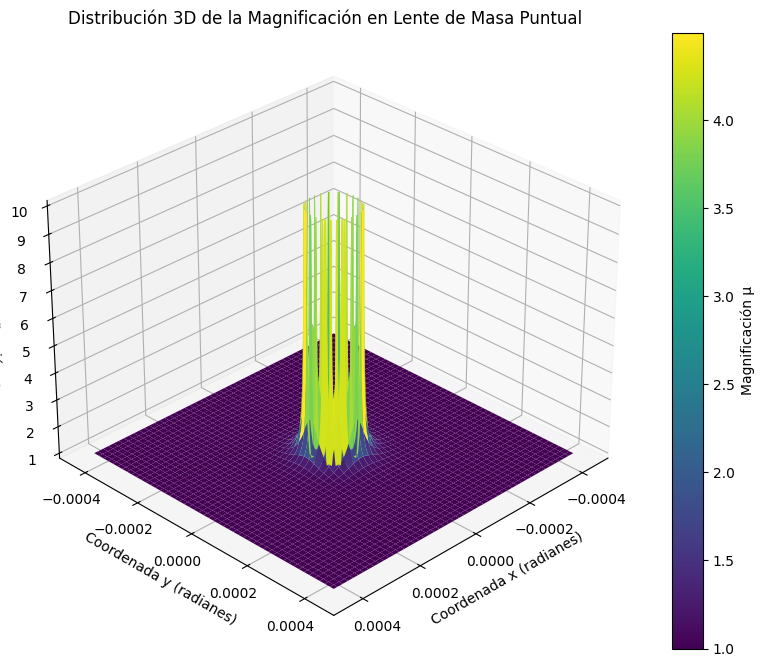

In [17]:
magnification = get_magnificacion(xx, yy)
print(magnification.shape, magnification.max(), magnification.min())
# Convertir a numpy para plotting
mag_np = magnification.detach().numpy()
#xx_np = xx_np.detach().numpy()
#yy_np = yy_np.detach().numpy()

# Crear gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear la superficie 3D
X, Y = np.meshgrid(xx[0], yy[:, 0])  # Usar las coordenadas x e y de la malla
surf = ax.plot_surface(X, Y, mag_np, cmap='viridis', edgecolor='none')

# Etiquetas y título
ax.set_xlabel('Coordenada x (radianes)')
ax.set_ylabel('Coordenada y (radianes)')
ax.set_zlabel('Magnificación μ')
ax.set_title('Distribución 3D de la Magnificación en Lente de Masa Puntual')

# Añadir una barra de color
plt.colorbar(surf, ax=ax, label='Magnificación μ')

# Ajustar vista
ax.view_init(elev=30, azim=45)
plt.show()

## 4. Microlensing

### 4.1. Lensing Function
---
- Recoge en una única funcion el proceso completo para aplicar la lente gravitacional a una imagen
- Se añade la opción **shift_x** para desplazar la Masa puntual del origen a lo largo del eje X

In [18]:
def lensing(src, fov, shift_x = 0):
    N = src.shape[1]
    fov_rad = fov * np.pi /180.0      # en radianes
    dx = fov_rad / (N-1)
    # malla angular centrada
    x = (torch.arange(N) - (N-1)/2.0) * dx
    y = (torch.arange(N) - (N-1)/2.0) * dx
    yy, xx = torch.meshgrid(y, x, indexing='ij')
    # -----------------------------
    # Deflexión (masa puntual)
    # -----------------------------
    r = torch.sqrt(xx**2 + yy**2) + 1e-12  # Parámetro b para cada pounto de la malla
    alpha_x = theta_E_rad**2 * xx / r**2
    alpha_y = theta_E_rad**2 * yy / r**2
    mask_x = alpha_x > xx.max()
    mask_y = alpha_y > yy.max()
    alpha_x[mask_x] = xx.max()
    alpha_y[mask_y] = yy.max()

    mask_x = alpha_x < xx.min()
    mask_y = alpha_y < yy.min()
    alpha_x[mask_x] = xx.min()
    alpha_y[mask_y] = yy.min()

    # ecuación de la lente: beta = theta - alpha
    beta_x = xx - alpha_x
    beta_y = yy - alpha_y
    # convertir beta -> índices de grid_sample en [-1,1]
    Px = beta_x / dx +(N-1)/2
    Py = beta_y / dx +(N-1)/2
    # -----------------------------
    # Ray-shooting con grid_sample
    # -----------------------------
    gx = 2.0*(Px/(N-1)) - 1 + shift_x
    gy = 2.0*(Py/(N-1)) - 1
    grid = torch.stack([gx, gy], dim=-1).unsqueeze(0)

    # aplicar ray-shooting
    lensed = F.grid_sample(src.unsqueeze(0), grid, mode='bilinear',
                           padding_mode='zeros', align_corners=True)[0]
    return lensed, gx


### 4.2 Imagen Astronomica
---
- Se genera una imagen con el doble de tamaño y doble FOV para evitarlas zonas vacias al desplazar y centrar la imagen
  

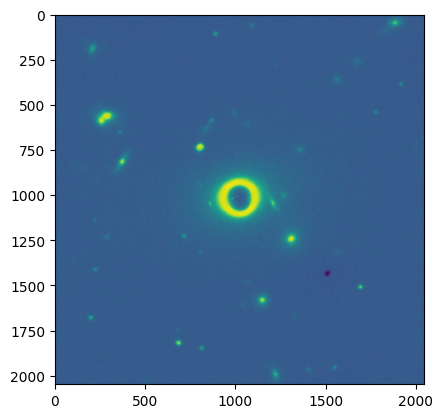

In [19]:
image_astro = get_Image_Astro(COORD, fov = 2*FOV, width = 2*PIX_X, height = 2*PIX_X, debug=False)
N_i = image_astro.shape[1]
src_i = torch.zeros((1, N_i, N_i))
src_i[0] =  torch.from_numpy(image_astro)
lensed_0, gx = lensing(src_i, 2* FOV, -0.0)
plt.imshow(lensed_0[0])
plt.show()



### 4.3 Generación de las Imágenes (Movimiento de la Fuente)
---

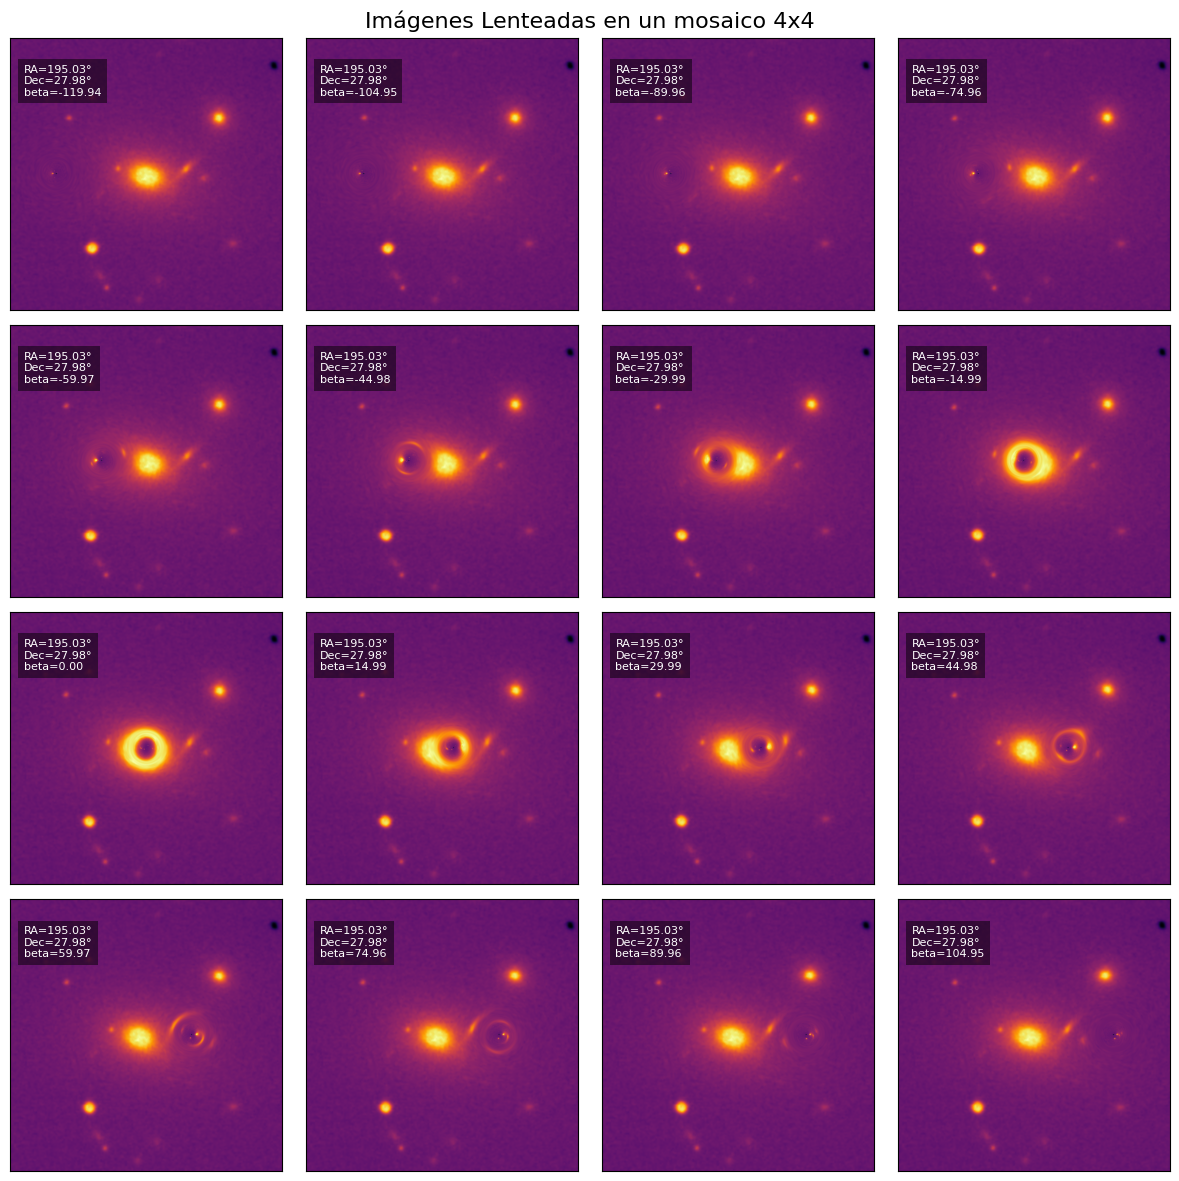

In [20]:
# -----------------------------
# Paráetros de Microlensing
# -----------------------------
Delta = gx.max()/3    # Variación maxima de la masa puntual en el plano de la fuente
N_lensed = 65         # Número de imágenes generadas
delta_vals = np.linspace(-Delta, +Delta, 65)

# -----------------------------
# Microlensing
# -----------------------------
fig, axes = plt.subplots(4,4, figsize=(12,12))
lensed_list_lens = []
img_n= 0
fov_arcsec = 2*FOV*3600
for i, delta in enumerate(delta_vals):
    lensed, gx_i = lensing(src_i, 3* FOV, delta)

    H, W = lensed[0].shape

    crop_size = PIX_X     # tamaño del recorte (pixeles)
    delta_x = 10       # desplazamiento en pixeles hacia la derecha (+)

    # Centro original
    cx, cy = W//2, H//2

    # Centro desplazado
    PIX_delta = W/(gx_i.max() - gx_i.min())

    cx_shifted = cx - delta* PIX_delta
    cy_shifted = cy   # no se desplaza en Y (puedes cambiarlo si quieres)
    x_min = int(max(cx_shifted - crop_size//2, 0))
    x_max = int(min(cx_shifted + crop_size//2, W))
    y_min = int(max(cy_shifted - crop_size//2, 0))
    y_max = int(min(cy_shifted + crop_size//2, H))
    # Recorte de la imagen
    lensed_crop = lensed[0,y_min:y_max, x_min:x_max]
    lensed_list_lens.append(lensed_crop)
    # Mostrar resultado
    if i%4 ==0 and img_n <16:
        ax = axes[img_n//4,img_n%4]
        ax.imshow(lensed_crop, origin='lower', cmap='inferno',
                  extent=[-fov_arcsec/2, fov_arcsec/2,
                          -fov_arcsec/2, fov_arcsec/2])
        ax.set_xticks([]); ax.set_yticks([])

        # Texto con RA y Dec dentro de cada imagen
        textstr = f"RA={COORD['RA']:.2f}°\nDec={COORD['Dec']:.2f}°\nbeta={delta*fov_arcsec:.2f}"
        ax.text(0.05, 0.90, textstr, transform=ax.transAxes,
                fontsize=8, color="white",
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'),
                ha='left', va='top')
        img_n+=1
plt.suptitle("Microlensing - MACHO Simlation", fontsize=16)
plt.tight_layout()
plt.show()


### 4.4. Variación del Flujo Luminoso
---
- Se integra el flujo dentro de un radio:
  $$R_\star < \frac{2}{3}\theta_E$$

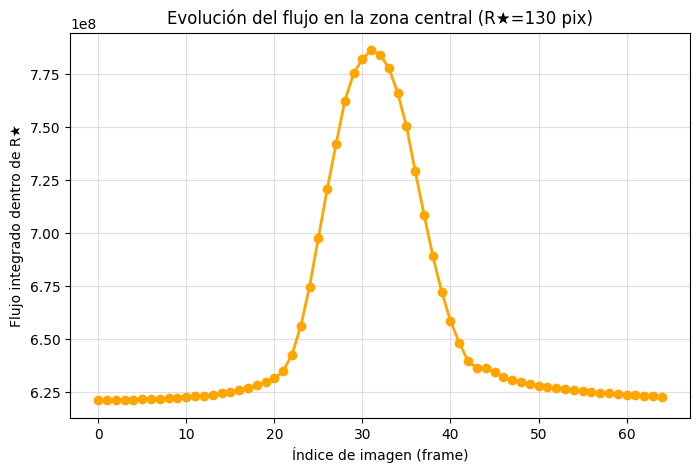

In [21]:
# Radio en píxeles para la región central
R_star = 1.5*theta_E_rad/dx

# Calcular flujo central en cada imagen
flux_list = []

for img in lensed_list_lens:
    H, W = img.shape
    y, x = np.ogrid[:H, :W]
    cx, cy = W//2, H//2
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    mask = torch.tensor(r <= R_star)
    #print(r.max(), r.min(), R_star, mask.shape, mask.sum())
    #print(type(img), type(mask))
    flux = torch.sum(img[mask])
    flux_list.append(flux)

# Convertir a array NumPy
flux_list = np.array(flux_list)

# -----------------------------
# Gráfico del flujo central
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(flux_list, 'o-', color='orange', lw=2)
plt.xlabel("Índice de imagen (frame)")
plt.ylabel("Flujo integrado dentro de R★")
plt.title(f"Evolución del flujo en la zona central (R★={int(R_star)} pix)")
plt.grid(True, alpha=0.4)
plt.show()

### 4.5. Microlensing. Movimiento de la Fuente

1. Imagen Descargada RA = 195.021, DEC = 27.977
2. Imagen Descargada RA = 195.022, DEC = 27.977
3. Imagen Descargada RA = 195.024, DEC = 27.977
4. Imagen Descargada RA = 195.026, DEC = 27.977
5. Imagen Descargada RA = 195.027, DEC = 27.977
6. Imagen Descargada RA = 195.029, DEC = 27.977
7. Imagen Descargada RA = 195.031, DEC = 27.977
8. Imagen Descargada RA = 195.032, DEC = 27.977
9. Imagen Descargada RA = 195.034, DEC = 27.977
10. Imagen Descargada RA = 195.036, DEC = 27.977
11. Imagen Descargada RA = 195.037, DEC = 27.977
12. Imagen Descargada RA = 195.039, DEC = 27.977
13. Imagen Descargada RA = 195.041, DEC = 27.977
14. Imagen Descargada RA = 195.042, DEC = 27.977
15. Imagen Descargada RA = 195.044, DEC = 27.977
16. Imagen Descargada RA = 195.046, DEC = 27.977


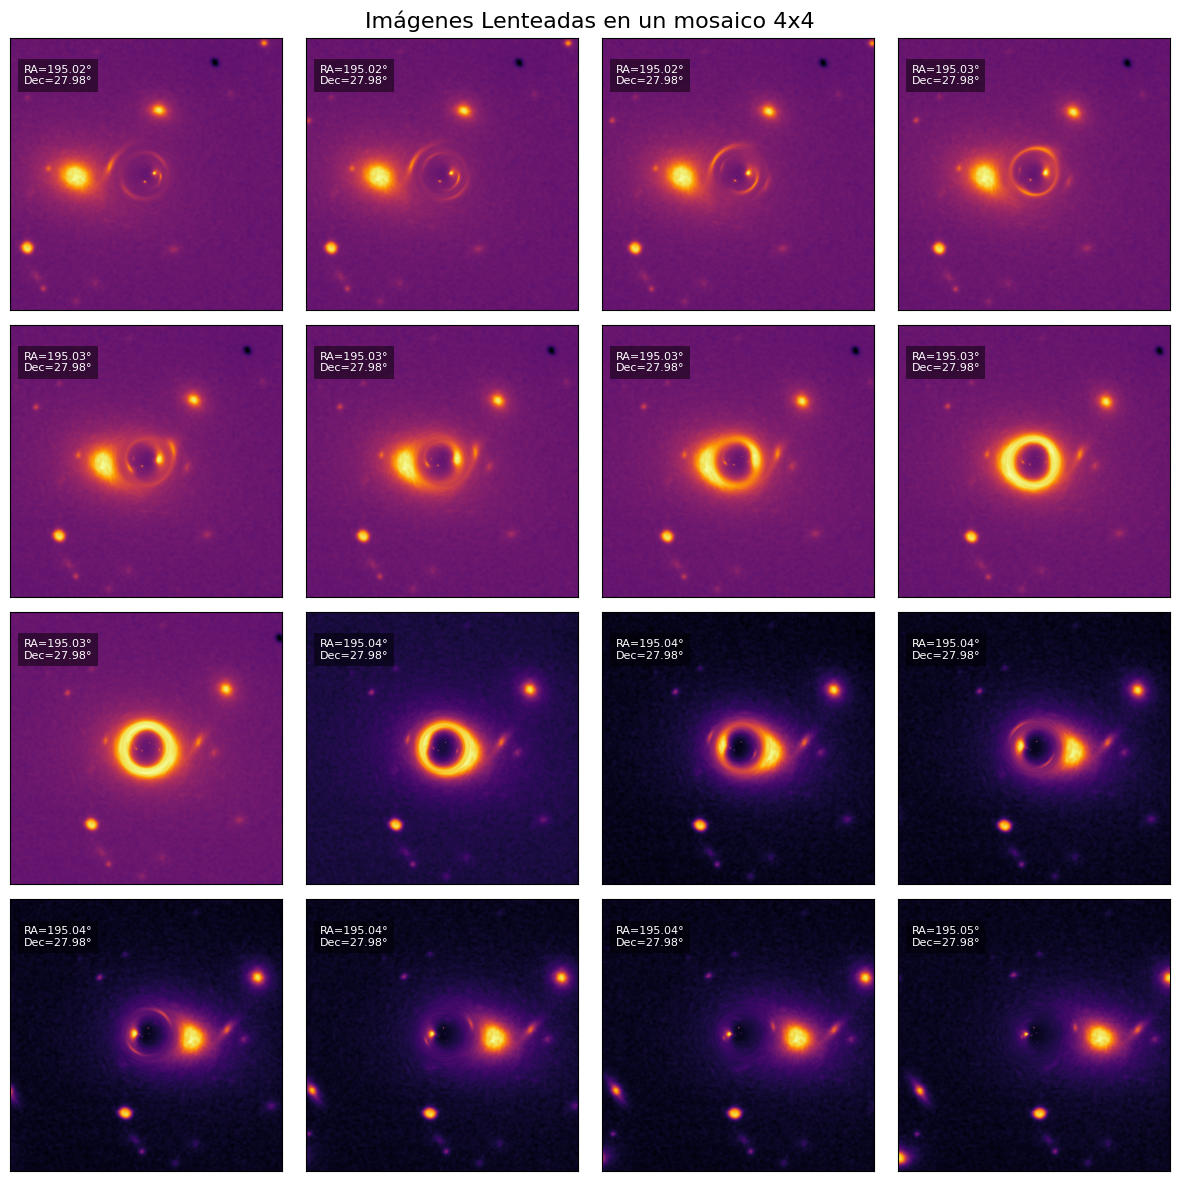

In [22]:
RA0, Dec0 = COORD['RA'], COORD['Dec']
Delta = FOV/4
RA_vals = np.linspace(RA0-Delta, RA0+Delta, 16)
#Dec_vals = np.linspace(Dec0-Delta, Dec0+Delta, 4)
# -----------------------------
# Microlensing
# -----------------------------
fig, axes = plt.subplots(4,4, figsize=(12,12))
lensed_list_source = []
for i, ra in enumerate(RA_vals):
    ax = axes[i//4,i%4]

    # Imagen fuente
    src_i = torch.zeros((1, N, N))
    coord = {'RA': ra, 'Dec': Dec0}
    src_i[0] =  torch.from_numpy(get_Image_Astro(coord, debug=False))

    print(f'{i+1}. Imagen Descargada RA = {ra:.3f}, DEC = {Dec0:.3f}')
    # Lensing (ray-shooting con grid_sample)
    lensed = F.grid_sample(src_i.unsqueeze(0), grid,
                           mode='bilinear', padding_mode='zeros',
                           align_corners=True)[0]
    lensed_list_source.append(lensed[0])
    # Mostrar resultado
    ax.imshow(lensed[0], origin='lower', cmap='inferno',
              extent=[-fov_arcsec/2, fov_arcsec/2,
                      -fov_arcsec/2, fov_arcsec/2])
    ax.set_xticks([]); ax.set_yticks([])

    # Texto con RA y Dec dentro de cada imagen
    textstr = f"RA={ra:.2f}°\nDec={Dec0:.2f}°"
    ax.text(0.05, 0.90, textstr, transform=ax.transAxes,
            fontsize=8, color="white",
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'),
            ha='left', va='top')

plt.suptitle("Imágenes Lenteadas en un mosaico 4x4", fontsize=16)
plt.tight_layout()
plt.show()

### 4.6. Microlensing - Animación

In [24]:
# -----------------------------
# Animación con Matplotlib
# -----------------------------
def update(frame):
    im.set_array(lensed_list_lens[frame])
    ax.set_title(f"Frame {frame+1}/{len(lensed_list_lens)}")
    return [im]

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(lensed_list_lens[0], cmap="inferno", origin="lower")
ax.set_title("Animación de Lentes Gravitacionales")

ani = animation.FuncAnimation(fig, update, frames=len(lensed_list_lens),
                              interval=500, blit=True)
ani.save("lensed_animation.gif", writer="pillow", fps=10)
Image(filename="lensed_animation.gif")


Output hidden; open in https://colab.research.google.com to view.

## 5. Perfil de Masa Distribuida

### 5.1. Halo NFW de Materia Oscura
---
El perfil Navarro-Frenk-White (NFW), derivado de simulaciones cosmológicas N-body, describe halos de materia oscura (DM) como esferas con una densidad que disminuye radialmente. Este perfil es "universal" para halos de DM fría (CDM) en modelos ΛCDM, con una cúspide central y una caída suave en las afueras.El perfil de densidad 3D del NFW es:
$$\rho(r) = \frac{\rho_s}{(r/r_s) (1 + r/r_s)^2}$$
- **Radio de Escala ($ r_s $):** Representa el radio donde el perfil transita de una pendiente interna pronunciada ($\rho \propto r^{-1}$, cúspide central) a una externa más suave ($\rho \propto r^{-3}$). Típicamente, $ r_s \approx 10-100 $ kpc para halos galácticos y hasta Mpc para cúmulos.
- **Densidad Característica ($ \rho_s $):** Es la densidad en $ r = r_s $, típicamente $ \rho_s \approx 10^6 - 10^8 \, M_\odot / \text{kpc}^3 $ para halos galácticos.
- **Concentración ($ c $):** Definida como $ c = r_{vir} / r_s $, donde $ r_{vir} $ es el radio virial (e.g., r_200, radio donde la densidad promedio es 200 veces la crítica). Valores típicos: c ≈ 5-15 para halos de galaxias, menor para cúmulos masivos. En modelos CDM, c depende de la masa del halo $(c\,\, \alpha\,\, M^{-0.1})$ y redshift, reflejando jerarquía de formación: halos pequeños se forman antes y son más concentrados.
- **Masa Virial ($ M_{vir} $ o $ M_{200} $):** Masa total dentro de $ r_{vir} $, típicamente $ M_{200} = \frac{4\pi}{3} r_{200}^3 \cdot 200 \rho_{cr} $, con $ \rho_{cr} = 3H^2 / (8\pi G) $ la densidad crítica.

<>:14: SyntaxWarning: invalid escape sequence '\,'
<>:14: SyntaxWarning: invalid escape sequence '\,'
<>:23: SyntaxWarning: invalid escape sequence '\,'
<>:14: SyntaxWarning: invalid escape sequence '\,'
<>:14: SyntaxWarning: invalid escape sequence '\,'
<>:23: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipython-input-746442346.py:14: SyntaxWarning: invalid escape sequence '\,'
  plt.loglog(r, rho, label=f'NFW Profile\n$\\rho_s = {rho_s} \, M_\\odot/\\text{{kpc}}^3$, $r_s = {r_s} \, \\text{{kpc}}$', color='blue')
/tmp/ipython-input-746442346.py:14: SyntaxWarning: invalid escape sequence '\,'
  plt.loglog(r, rho, label=f'NFW Profile\n$\\rho_s = {rho_s} \, M_\\odot/\\text{{kpc}}^3$, $r_s = {r_s} \, \\text{{kpc}}$', color='blue')
/tmp/ipython-input-746442346.py:23: SyntaxWarning: invalid escape sequence '\,'
  plt.axvline(x=r_s, color='red', linestyle='--', label=f'$r_s = {r_s} \, \\text{{kpc}}$')


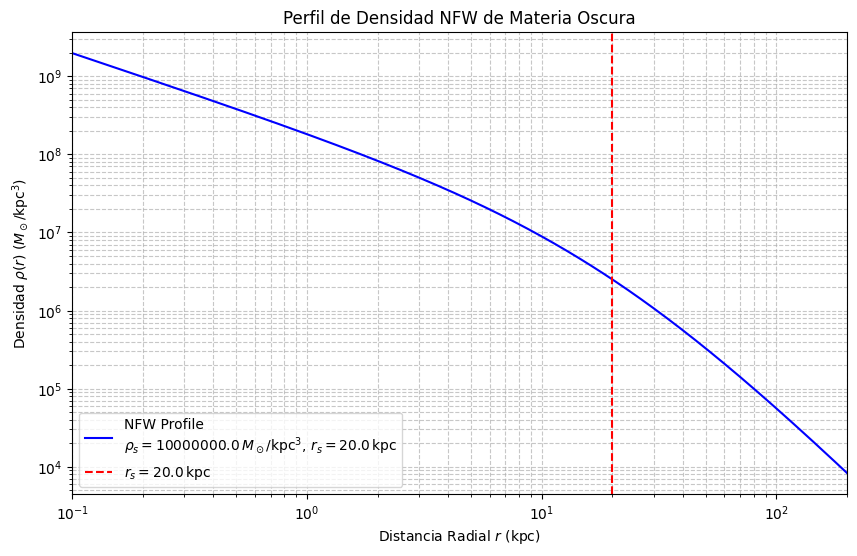

In [25]:
# Definir parámetros del perfil NFW
rho_s = 1e7  # Densidad característica en M☉/kpc³ (ejemplo típico para un halo galáctico)
r_s = 20.0   # Radio de escala en kpc (ajustable según el halo)
r_max = 200.0  # Límite superior de r para la gráfica en kpc

# Generar un rango de distancias radiales
r = np.logspace(-1, np.log10(r_max), 500)  # Rango logarítmico de 0.1 a r_max kpc

# Calcular la densidad rho(r) según el perfil NFW
rho = rho_s / ((r / r_s) * (1 + r / r_s)**2)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.loglog(r, rho, label=f'NFW Profile\n$\\rho_s = {rho_s} \, M_\\odot/\\text{{kpc}}^3$, $r_s = {r_s} \, \\text{{kpc}}$', color='blue')
plt.xlabel('Distancia Radial $r$ (kpc)')
plt.ylabel('Densidad $\\rho(r)$ ($M_\\odot/\\text{kpc}^3$)')
plt.title('Perfil de Densidad NFW de Materia Oscura')
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()
plt.xlim(r[0], r[-1])

# Añadir una línea vertical para r_s
plt.axvline(x=r_s, color='red', linestyle='--', label=f'$r_s = {r_s} \, \\text{{kpc}}$')
plt.legend()

plt.show()

### 3.3.

 Para lentes extendidas (e.g., galaxias o halos de DM), se integra el potencial:
$$\vec{\alpha}(\vec{\xi}) = \frac{4G}{c^2} \int \frac{\Sigma(\vec{\xi}') (\vec{\xi} - \vec{\xi}')}{|\vec{\xi} - \vec{\xi}'|^2} d^2\xi'$$
con $ \Sigma $ la densidad de masa superficial proyectada, y $ \vec{\xi} $ la posición en el plano de la lente.

## 4.
---
